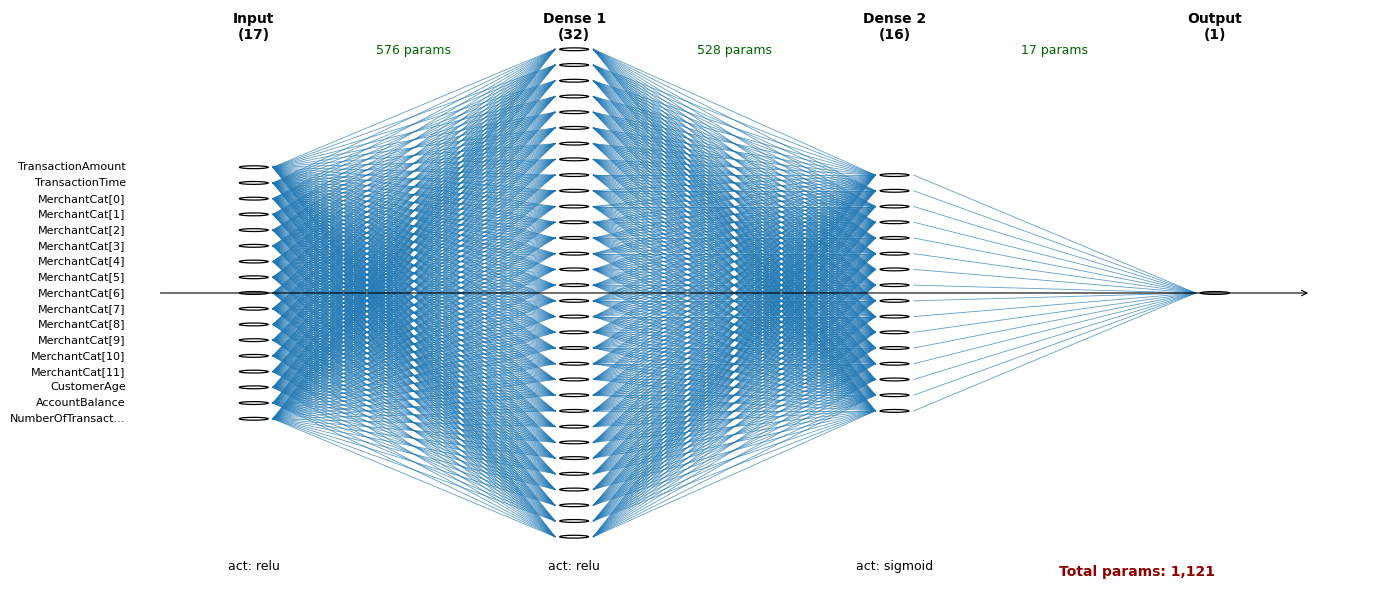

Saved diagram to: fraud_nn.png
Layer sizes: [17, 32, 16, 1]
Total parameters: 1,121


In [8]:
#!/usr/bin/env python3
"""
visualize_fraud_nn.py

Visualize a feed-forward neural network architecture for binary classification of credit-card fraud.

Example:
  python visualize_fraud_nn.py --merchant_cardinality 12 --merchant_mode onehot \
      --hidden 64,32 --out fraud_net.png

Defaults:
  merchant_cardinality=12, merchant_mode='onehot', hidden=[32,16], output='sigmoid' (1 node)

Dependencies:
  pip install matplotlib
"""

import argparse
import os
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.lines import Line2D

# Dataset raw feature names (excluding target)
RAW_FEATURES = [
    "TransactionAmount",
    "TransactionTime",
    "MerchantCategory",  # categorical -> expands
    "CustomerAge",
    "AccountBalance",
    "NumberOfTransactionsToday",
]

def build_input_representation(merchant_mode="onehot", merchant_cardinality=3, embedding_dim=8):
    """
    Return (input_size, input_labels) depending on how MerchantCategory is represented.

    merchant_mode: "onehot" or "embedding" or "index"
      - "onehot": MerchantCategory -> merchant_cardinality separate binary inputs
      - "embedding": MerchantCategory -> embedding_dim continuous inputs (learned embedding)
      - "index": MerchantCategory represented as single integer input (rarely used directly)
    """
    labels = []
    for feat in RAW_FEATURES:
        if feat != "MerchantCategory":
            labels.append(feat)
        else:
            if merchant_mode == "onehot":
                # create labelled one-hot entries
                for i in range(merchant_cardinality):
                    labels.append(f"MerchantCat[{i}]")
            elif merchant_mode == "embedding":
                # embedding dimension inputs, label Emb[0], Emb[1]...
                for i in range(embedding_dim):
                    labels.append(f"MerchantEmb[{i}]")
            elif merchant_mode == "index":
                labels.append("MerchantCategoryIndex")
            else:
                raise ValueError("merchant_mode must be one of: onehot, embedding, index")
    input_size = len(labels)
    return input_size, labels

def param_count(prev, units):
    """Return number of params (weights + biases) from prev -> units."""
    return units * (prev + 1)  # +1 for bias per unit

def visualize_nn(layers, layer_names=None, activations=None, input_labels=None,
                 figsize=(12,6), filename="fraud_nn.png", show=True):
    """
    Draw the network and annotate parameter counts.

    layers: list[int] including input layer as first element.
    input_labels: list[str] with length == layers[0] to annotate each input neuron
    """
    n_layers = len(layers)
    if layer_names is None:
        layer_names = []
        for i in range(n_layers):
            if i == 0:
                layer_names.append("Input")
            elif i == n_layers - 1:
                layer_names.append("Output")
            else:
                layer_names.append(f"Hidden {i}")
    if activations is None:
        activations = [""] * (n_layers - 1)

    fig, ax = plt.subplots(figsize=figsize)
    x_spacing = 2.0
    xs = [i * x_spacing for i in range(n_layers)]
    max_neurons = max(layers)
    ax.set_xlim(-1.0, xs[-1] + 1.0)
    ax.set_ylim(-max_neurons/2.0 - 2.0, max_neurons/2.0 + 2.0)
    ax.axis('off')

    # compute neuron coords
    coords = []
    for i, n in enumerate(layers):
        x = xs[i]
        layer_coords = []
        for j in range(n):
            # place neurons centered vertically
            y = ((n - 1) / 2.0) - j
            layer_coords.append((x, y))
        coords.append(layer_coords)

    # draw connections (all-to-all between consecutive layers)
    for i in range(n_layers - 1):
        for (x1, y1) in coords[i]:
            for (x2, y2) in coords[i+1]:
                line = Line2D([x1 + 0.12, x2 - 0.12], [y1, y2], linewidth=0.6, alpha=0.7)
                ax.add_line(line)

    # neuron circle size
    neuron_radius = 0.18 * max(0.5, 8.0 / max_neurons)

    # draw neurons
    for i, layer in enumerate(coords):
        for (x, y) in layer:
            circ = Circle((x, y), neuron_radius, fill=False, linewidth=0.9)
            ax.add_patch(circ)

    # annotate layer names and activations
    for i, (name, n) in enumerate(zip(layer_names, layers)):
        x = xs[i]
        ax.text(x, max_neurons/2.0 + 0.9, f"{name}\n({n})", ha='center', va='center', fontsize=10, weight='bold')
        if i < len(activations) and activations[i]:
            ax.text(x, -max_neurons/2.0 - 1.4, f"act: {activations[i]}", ha='center', va='center', fontsize=9)

    # annotate input labels (shortened) next to input neurons
    if input_labels:
        in_x = xs[0]
        # we assume layers[0] == len(input_labels)
        for idx, lab in enumerate(input_labels):
            _, y = coords[0][idx]
            # if label is long, wrap or shorten
            short = lab if len(lab) <= 18 else lab[:16] + "…"
            ax.text(in_x - 0.8, y, short, ha='right', va='center', fontsize=8)

    # compute and annotate parameter counts per layer (between layers)
    total_params = 0
    for i in range(n_layers - 1):
        prev = layers[i]
        units = layers[i+1]
        p = param_count(prev, units)
        total_params += p
        # place annotation midway between layers
        mx = (xs[i] + xs[i+1]) / 2.0
        ay = max_neurons/2.0 - 0.6
        ax.text(mx, ay, f"{p:,} params", ha='center', va='center', fontsize=9, color='darkgreen')

    ax.text(xs[-1], -max_neurons/2.0 - 2.0, f"Total params: {total_params:,}", ha='right', fontsize=10, color='darkred', weight='bold')

    # arrow showing flow
    ax.annotate("", xy=(xs[-1] + 0.6, 0), xytext=(xs[0] - 0.6, 0),
                arrowprops=dict(arrowstyle="->", linewidth=0.8))

    plt.tight_layout()
    outdir = os.path.dirname(os.path.abspath(filename))
    if outdir and not os.path.exists(outdir):
        os.makedirs(outdir, exist_ok=True)
    plt.savefig(filename, dpi=220, bbox_inches='tight')
    if show:
        plt.show()
    print(f"Saved diagram to: {filename}")
    print(f"Layer sizes: {layers}")
    print(f"Total parameters: {total_params:,}")

def parse_hidden(s):
    if s is None or s.strip() == "":
        return []
    return [int(x) for x in s.split(",") if x.strip()]

def main():
    parser = argparse.ArgumentParser(description="Visualize NN architecture for fraud detection dataset")
    parser.add_argument("--merchant_cardinality", type=int, default=12,
                        help="Number of distinct MerchantCategory values (used for one-hot size)")
    parser.add_argument("--merchant_mode", choices=["onehot", "embedding", "index"], default="onehot",
                        help="How to represent MerchantCategory inputs")
    parser.add_argument("--embedding_dim", type=int, default=8,
                        help="Embedding dimension if merchant_mode=embedding")
    parser.add_argument("--hidden", type=str, default="32,16",
                        help="Comma-separated hidden layer sizes (e.g. 64,32). Default=32,16")
    parser.add_argument("--output_mode", choices=["sigmoid", "softmax"], default="sigmoid",
                        help="sigmoid => 1 output node (binary); softmax => 2 output nodes")
    parser.add_argument("--out", type=str, default="fraud_nn.png", help="Output filename (png/svg/pdf)")
    parser.add_argument("--no_show", action="store_true", help="Do not call plt.show()")
    # Fix: Pass an empty list to parse_args() to prevent it from trying to parse kernel arguments.
    args = parser.parse_args([])

    hidden = parse_hidden(args.hidden)
    # build input representation
    in_size, input_labels = build_input_representation(
        merchant_mode=args.merchant_mode,
        merchant_cardinality=args.merchant_cardinality,
        embedding_dim=args.embedding_dim)

    # final output layer
    if args.output_mode == "sigmoid":
        out_units = 1
        out_act = "sigmoid"
    else:
        out_units = 2
        out_act = "softmax"

    # full layers list includes input as first entry
    layers = [in_size] + hidden + [out_units]
    # layer names: Input, Hidden i..., Output
    layer_names = ["Input"] + [f"Dense {i+1}" for i in range(len(hidden))] + ["Output"]
    # activations list covers layers after input (len = len(layers)-1)
    acts = []
    for i in range(len(hidden)):
        acts.append("relu")
    acts.append(out_act)

    visualize_nn(layers, layer_names=layer_names, activations=acts, input_labels=input_labels,
                 figsize=(14,6), filename=args.out, show=(not args.no_show))

if __name__ == "__main__":
    main()
